## EXPLORE Data Science Academy Classification Hackathon

**Overview**

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages. 
With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

## Importing Libraries

In [42]:
import pandas as pd
import numpy as np
import re
import string

import codecs

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import feature_extraction
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics


# Models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn import metrics
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import warnings
warnings.simplefilter("ignore")

## Loading Data

In [2]:
df = pd.read_csv('train_set.csv', encoding='UTF-8')
test_df = pd.read_csv('test_set.csv' ,encoding='UTF-8')
df_copy = df.copy()

In [3]:
df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


## Exploratory Data Analysis

In [6]:
df.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,afr,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


The dataset has a count of 33000 features for text and lang_id. 11 unique features for the lang_id and 29948 unique features for the text. The frequency for the lang_id is 3000 and 17 for the text features.

In [7]:
#Checking for null objects in train data
df.isnull().sum()

lang_id    0
text       0
dtype: int64

The dataset has no null features.

In [8]:
#Checking the length of the characters
df_copy['length'] = df_copy['text'].apply(lambda x: len(x))

In [9]:
display(df.shape)

(33000, 2)

The dataset has 2 columns and 33000 rows

In [11]:
value_counts = df["lang_id"].value_counts()
value_counts.name = "Raw Number"

value_normd = df["lang_id"].value_counts(normalize=True)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))

,Raw Number,Percentage
afr,3000,0.090909
tso,3000,0.090909
sot,3000,0.090909
ssw,3000,0.090909
zul,3000,0.090909
nbl,3000,0.090909
nso,3000,0.090909
tsn,3000,0.090909
ven,3000,0.090909
xho,3000,0.090909


In [13]:
from copy import deepcopy
df1 = deepcopy(df)

In [19]:
df1.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


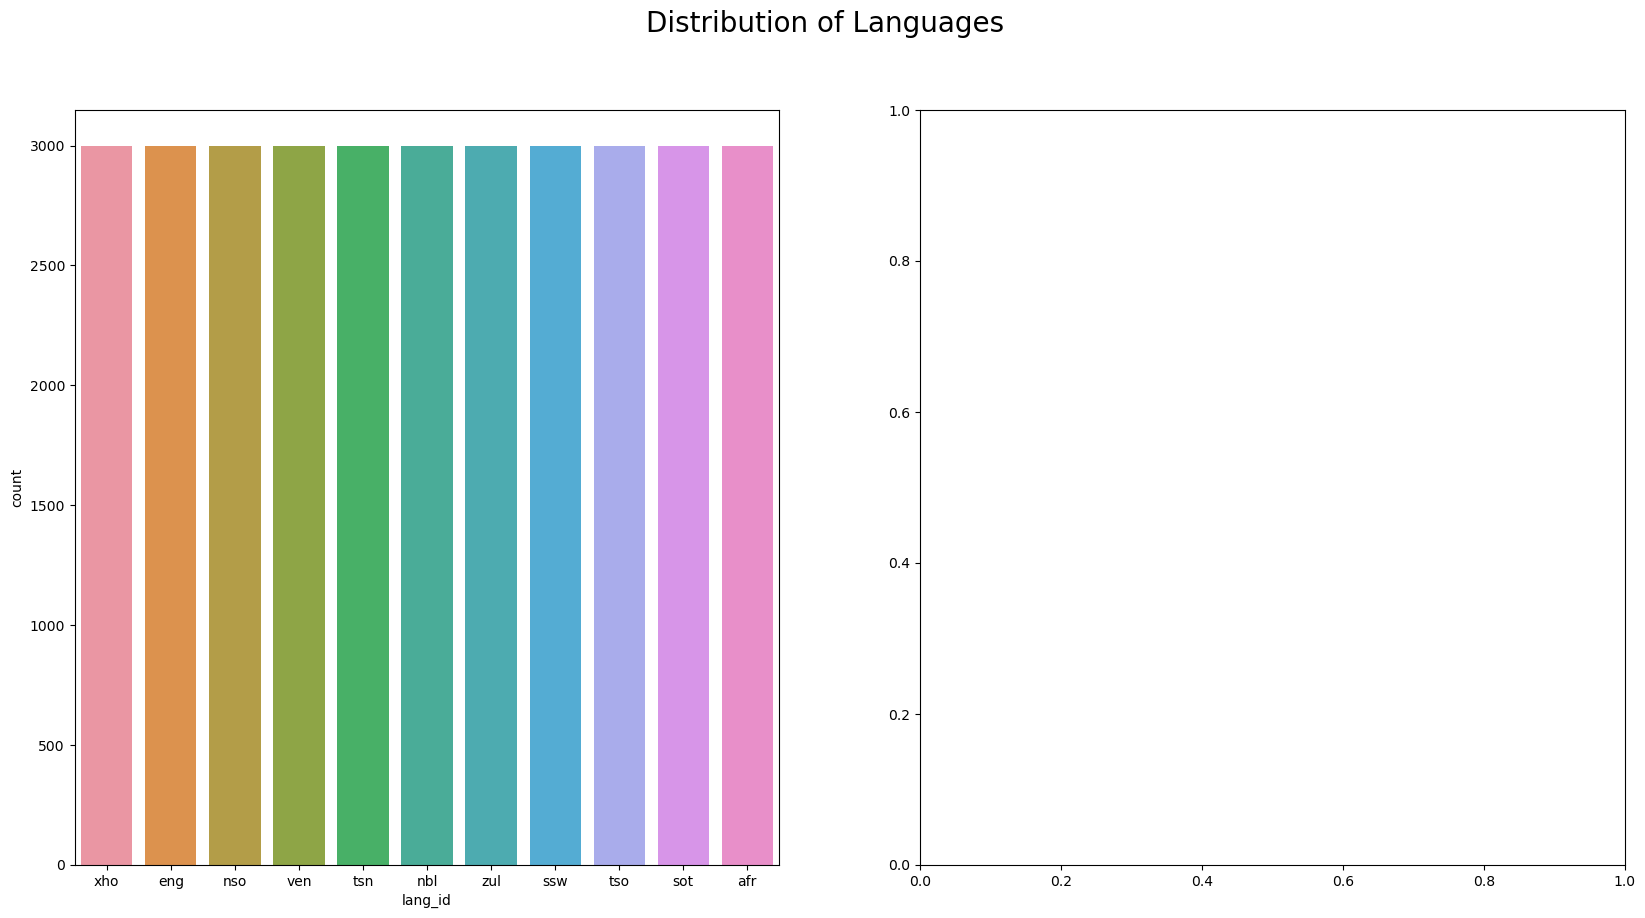

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=100)

sns.countplot(df1["lang_id"], ax=axes[0])


fig.suptitle("Distribution of Languages", fontsize=20)
plt.show()

The languages have an equal distribution with each having a count of 3000

## Text Cleaning

In [25]:
#Remove Punctuations
def _remove_punc(x):
    x = re.sub(r'[-]',' ',x)
    x = re.sub(r'[_]', ' ', x)
    x = re.sub(r'[^\w\s]','',x)
    x = re.sub('[0-9]+', '', x)
    x = re.sub(r'[^\x00-\x7f]',r'', x)
    return x

#Apply the function to the dataset
df_copy['clean_punc'] = df_copy['text'].apply(_remove_punc)

In [27]:
#Making the characters in the text a lower case
def _lower(x):
    return x.lower()
df_copy['lower'] = df_copy['clean_punc'].apply(_lower)

In [30]:
from nlppreprocess import NLP

In [31]:
#Remove Stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(x):
    stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    x = stopwords.process(x)
    return x

#Applying the function to the dataset   
df_copy['Text_nonstop'] = df_copy['lower'].apply(lambda x: remove_stopwords(x))

The function above removed english stopwords in the dataset to reduce noise.

In [35]:
def _analyzer (l):
    l = _remove_punc(l)
    l = _lower(l)
    l = remove_stopwords(l)
    return l

The above function combines all the cleaning operations applied to the dataset and returns a dataset in lower case, no punctuations and with no stopwords

In [36]:
df_copy.head()

,lang_id,text,length,clean_punc,lower,Text_nonstop
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,220,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,252,i dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...,dha iya kuba nobulumko bokubeka umsebenzi naph...
2,eng,the province of kwazulu-natal department of tr...,264,the province of kwazulu natal department of tr...,the province of kwazulu natal department of tr...,province kwazulu natal department transport in...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,217,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


**Applying the analyzer function to both the train and test data to remove punctuations, stopwords and make the texts in lower case**

In [37]:
df['cleaned'] = df['text'].apply(_analyzer)
test_df['cleaned'] = test_df['text'].apply(_analyzer)

## Training the Dataset and Applying the Models

In [39]:
# Splitting  X (indepedent) and Y (target/dependent) variables
X = df['cleaned']
y = df['lang_id']

In [40]:
X_train , X_test , y_train , y_test = train_test_split(X , y, stratify=y,
                                                       test_size =0.4, 
                                                       random_state=42)

The different models that will be applied to the dataset and their performances compared

In [43]:
algo = [LogisticRegression(random_state =42 , max_iter=5000) , 
       MultinomialNB(), LinearSVC(random_state=42), 
       SGDClassifier(random_state=42), RidgeClassifier(random_state=42)]

In [44]:
def _performace_assesment(*args , **kwargs):
  model_stats = {}
  for clf in algo:
    model = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')),
                      ('clf' , clf)
                      ])
    
    model.fit(X_train, y_train) #Training
    model_pred = model.predict(X_test) #Testing

    # Dictionary of Models Performances
    model_stats[clf.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, model_pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, model_pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, model_pred, average='weighted')}
  return pd.DataFrame.from_dict(model_stats, orient='index')

In [45]:
performance = _performace_assesment(algo , X_train , X_test , y_train , y_test)
performance.to_csv('performance.csv')
dataframe = pd.read_csv('performance.csv', index_col = 0)
dataframe.sort_values('F1-Weighted', ascending=False)

,F1-Macro,F1-Accuracy,F1-Weighted
MultinomialNB,0.999394,0.999394,0.999394
RidgeClassifier,0.999167,0.999167,0.999167
LinearSVC,0.999167,0.999167,0.999167
SGDClassifier,0.999091,0.999091,0.999091
LogisticRegression,0.998183,0.998182,0.998183


## Hyperparameter Tuning and Model Validation

Hyperparameter tuning is the method of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter, on the other hand, is a variable or argument whose value is set before the training process begins. Hyperparameter tuning finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given data.

In [46]:
def _param_tuning(*args , **kwargs):
  best_params = {}

  for clf in algo:
    model = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')),
                      ('clf' , clf)])
    model.fit(X_train, y_train) #Training
    
    #Get models performing parameters
    params = model.get_params()
    model_name = clf.__class__.__name__ 
    model_name = {}
    for key in params:
      if key.startswith("clf"):
        if len(key) < 5:
          model_name['model'] = params[key]
        else:
            model_name[key[5:]] = params[key]
    best_params[clf.__class__.__name__] = model_name
  return best_params

In [47]:
best_params = _param_tuning(algo, X_train, y_train)

In [48]:
#Best parameters
best_params

{'LogisticRegression': {'model': LogisticRegression(max_iter=5000, random_state=42),
  'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 5000,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'MultinomialNB': {'model': MultinomialNB(),
  'alpha': 1.0,
  'class_prior': None,
  'fit_prior': True},
 'LinearSVC': {'model': LinearSVC(random_state=42),
  'C': 1.0,
  'class_weight': None,
  'dual': True,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'loss': 'squared_hinge',
  'max_iter': 1000,
  'multi_class': 'ovr',
  'penalty': 'l2',
  'random_state': 42,
  'tol': 0.0001,
  'verbose': 0},
 'SGDClassifier': {'model': SGDClassifier(random_state=42),
  'alpha': 0.0001,
  'average': False,
  'class_weight': None,
  'early_stopping': False,
  'epsilon': 0.1,
  'eta0': 0.0,
  'fit_intercept': 

## Modelling

In [53]:
#model
model1 = MultinomialNB()

The first modelling used was **Multinomial Naive Bayes Classifier**. It is suitable for classification with discrete features (e.g., word counts for text classification). 

In [54]:
Vectorize = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')
X_train = Vectorize.fit_transform(X_train)
X_test = Vectorize.transform(X_test)

In [55]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                   random_state=42)

**Stratified K-Folds cross-validator.**

It provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [56]:
best_params[alg[1].__class__.__name__]

{'model': MultinomialNB(),
 'alpha': 1.0,
 'class_prior': None,
 'fit_prior': True}

In [57]:
alpha = list(np.linspace(0.1,0.02,4))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model1,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [58]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [59]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9996969686252897
Test score: 0.9995455174533855


MultinomialNB(alpha=0.04666666666666667)

In [60]:
#model
model2 = RidgeClassifier()

The second model applied to the dataset was **Ridge Classifier**

This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).

In [61]:
best_params[alg[4].__class__.__name__]

{'model': RidgeClassifier(random_state=42),
 'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

In [62]:
alpha = list(np.linspace(0.15,0.4, 5))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model2,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [63]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [64]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9994949477404799
Test score: 0.9990909717224429


RidgeClassifier(alpha=0.275)

## Predictions

**Stack Classifier**

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

In [65]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [66]:
X_train , X_test , y_train , y_test = train_test_split(X, y,  stratify=y, test_size=0.4, random_state =1)

In [67]:
vect = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(2, 6), analyzer= 'char')
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [68]:
multiNB1 = MultinomialNB(alpha=0.1)
multiNB2 = MultinomialNB(alpha=0.1)

estimators = [('multiNB1', multiNB1), ('multiNB2', multiNB2)]
final_est = RidgeClassifier(alpha=0.2125)

In [69]:
stacking_NB2 = StackingClassifier(estimators = estimators,
                           final_estimator = final_est,
                           passthrough = True)

In [70]:
stacking_NB2.fit(X_train , y_train)

StackingClassifier(estimators=[('multiNB1', MultinomialNB(alpha=0.1)),
                               ('multiNB2', MultinomialNB(alpha=0.1))],
                   final_estimator=RidgeClassifier(alpha=0.2125),
                   passthrough=True)

In [71]:
pred = stacking_NB2.predict(X_test)

In [72]:
model_stats = {}
model_stats[stacking_NB2.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, pred, average='weighted')}
pd.DataFrame.from_dict(model_stats, orient='index')

,F1-Macro,F1-Accuracy,F1-Weighted
StackingClassifier,0.999773,0.999773,0.999773


In [74]:
count_vec = CountVectorizer(ngram_range=(3,7), analyzer= 'char')
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify=y,test_size=0.05, random_state =1)
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

In [75]:
multiNB1 = MultinomialNB(alpha=0.1)
multiNB2 = MultinomialNB(alpha=0.1)
multiNB3 = MultinomialNB(alpha=0.1)

estimators = [('multiNB1', multiNB1), ('multiNB2', multiNB2), ('multiNB3', multiNB3)]
final_est = RidgeClassifier(alpha=0.2125)

In [77]:
#stacking_NB3 = StackingClassifier(estimators = estimators,
                           #final_estimator = final_est,
                           #passthrough = True)

In [ ]:
#stacking_NB3.fit(X_train , y_train)
#I interrupted/stopped this . It took forever but gives better accuracy

In [ ]:
#pred = stacking_NB3.predict(X_test)

In [78]:
model_stats = {}
model_stats[stacking_NB3.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, pred, average='weighted')}
pd.DataFrame.from_dict(model_stats, orient='index')

ValueError: Found input variables with inconsistent numbers of samples: [1650, 13200]

In [80]:
X = test_df['cleaned']
Vectorize = vect.transform(X)

In [81]:
test_df['lang_id'] = stacking_NB2.predict(Vectorize)

## Creating Kaggle Submission

In [82]:
submission = test_df[['index', 'lang_id']]
submission.to_csv('Diana_Okeyo.csv',index=False)
submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot


In [84]:
perf_df = pd.read_csv('performance.csv')
perf_df.head()

,Unnamed: 0,F1-Macro,F1-Accuracy,F1-Weighted
0,LogisticRegression,0.998183,0.998182,0.998183
1,MultinomialNB,0.999394,0.999394,0.999394
2,LinearSVC,0.999167,0.999167,0.999167
3,SGDClassifier,0.999091,0.999091,0.999091
4,RidgeClassifier,0.999167,0.999167,0.999167
